#MODEL 1:Collaborative filtering model using k-Nearest Neighbors (k-NN)

## install requirements

In [ ]:
!git clone https://github.com/tensorflow/examples
%cd examples/lite/examples/recommendation/ml/
!pip install -r requirements.txt

Cloning into 'examples'...
remote: Enumerating objects: 23745, done.
remote: Total 23745 (delta 0), reused 0 (delta 0), pack-reused 23745
Receiving objects: 100% (23745/23745), 44.08 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (12948/12948), done.
/content/examples/lite/examples/recommendation/ml


## libraries and dataset installation

In [ ]:
!pip install surprise
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


In [ ]:
# Download and unzip the dataset
DATASET_LINK = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!wget -nc $DATASET_LINK
!unzip -n ml-100k.zip

# Load the dataset
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('ml-100k/u.data', sep='\t', names=column_names)

# Load item information
item_info = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
item_info = item_info[[0, 1]]
item_info.columns = ['item_id', 'title']

# Display basic info
print("Dataset info:")
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())


--2024-07-04 20:52:46--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  15.3MB/s    in 0.3s    

2024-07-04 20:52:46 (15.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


## Movielens dataset

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [ ]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# Load the dataset
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('ml-100k/u.data', sep='\t', names=column_names)

# Load item information
item_info = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
item_info = item_info[[0, 1]]
item_info.columns = ['item_id', 'title']

# Display basic info
print("Dataset info:")
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

First few rows of the dataset:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Create a pivot table
user_item_matrix = data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
user_item_sparse_matrix = csr_matrix(user_item_matrix.values)

# Fit the k-NN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## Define the Recommendation Function

In [ ]:
def recommend_movies(user_id, num_recommendations=5):
    distances, indices = knn.kneighbors(user_item_matrix.loc[user_id, :].values.reshape(1, -1), n_neighbors=num_recommendations+1)
    indices = indices.flatten()
    distances = distances.flatten()

    recommendations = []
    for i in range(1, len(indices)):
        movie_id = user_item_matrix.columns[indices[i]]
        recommendations.append((item_info[item_info['item_id'] == movie_id]['title'].values[0], distances[i]))

    return recommendations

##Get recommendation for a user

In [ ]:
# Get recommendations for a user
user_id = 3
num_recommendations = 15
recommendations = recommend_movies(user_id, num_recommendations)

print(f"Top {num_recommendations} recommendations for User {user_id}:")
for i, (title, distance) in enumerate(recommendations):
    print(f"{i+1}: {title} (distance: {distance})")


Top 15 recommendations for User 3:
1: Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970) (distance: 0.5109682057285196)
2: Notorious (1946) (distance: 0.514075473740512)
3: Night of the Living Dead (1968) (distance: 0.5170790656883248)
4: Hour of the Pig, The (1993) (distance: 0.531165810609274)
5: Beyond Bedlam (1993) (distance: 0.5325576087248058)
6: In the Name of the Father (1993) (distance: 0.5372323649899484)
7: Replacement Killers, The (1998) (distance: 0.5449485329842954)
8: Circle of Friends (1995) (distance: 0.5460269903577735)
9: How to Be a Player (1997) (distance: 0.5545039809855525)
10: Kids (1995) (distance: 0.5561300816166361)
11: My Life as a Dog (Mitt liv som hund) (1985) (distance: 0.5626145279273538)
12: Two Bits (1995) (distance: 0.5656209837704875)
13: Tin Cup (1996) (distance: 0.5793654168793101)
14: Milk Money (1994) (distance: 0.5816611039544359)
15: Cape Fear (1962) (distance: 0.5835093530673334)


## Visualising rating distribution

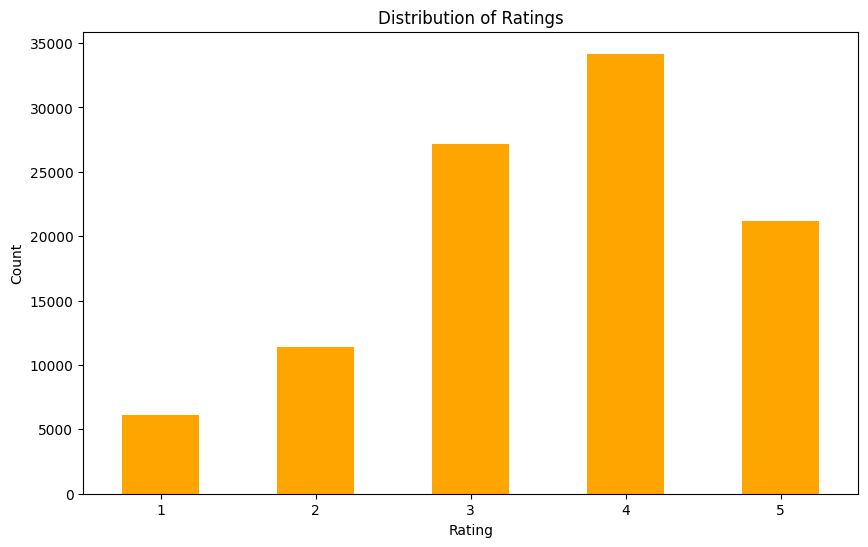

In [ ]:
import matplotlib.pyplot as plt

# Rating distribution
plt.figure(figsize=(10, 6))
data['rating'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


##Visualising top recommendations

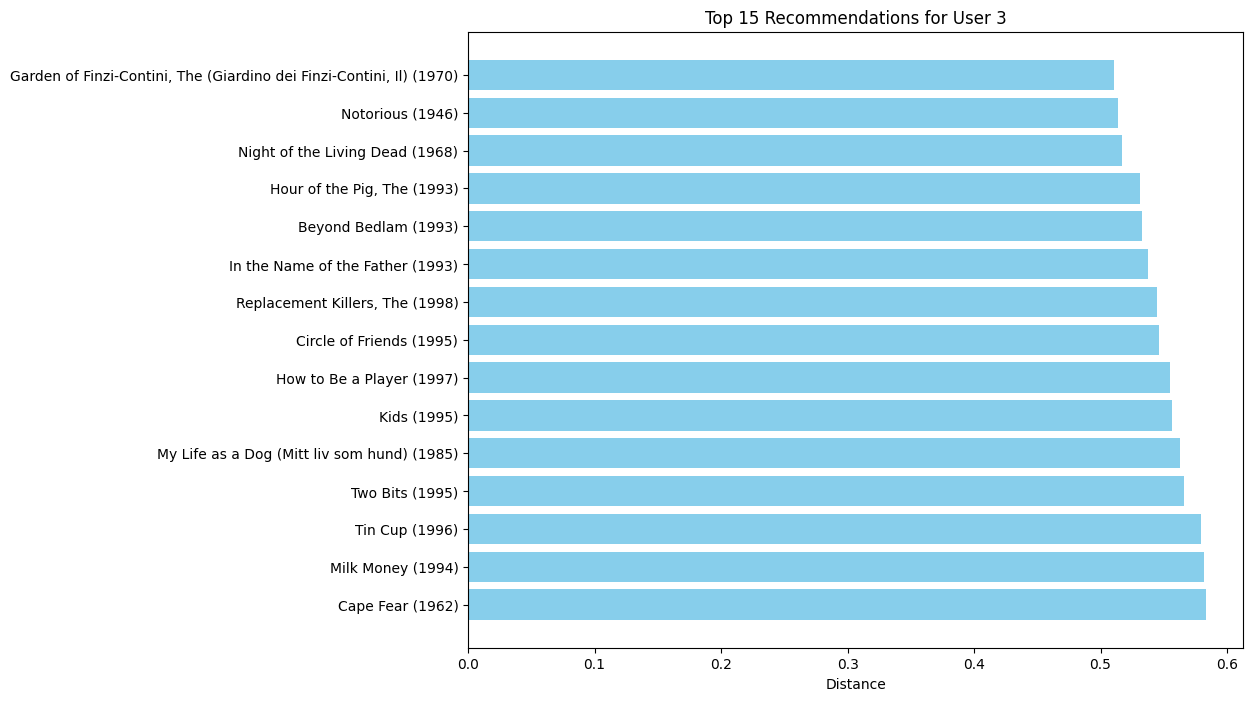

In [ ]:
def recommend_movies_visual(user_id, num_recommendations=5,clr='skyblue'):
    distances, indices = knn.kneighbors(user_item_matrix.loc[user_id, :].values.reshape(1, -1), n_neighbors=num_recommendations+1)
    indices = indices.flatten()
    distances = distances.flatten()

    recommendations = []
    for i in range(1, len(indices)):
        movie_id = user_item_matrix.columns[indices[i]]
        title = item_info[item_info['item_id'] == movie_id]['title'].values[0]
        recommendations.append((title, distances[i]))

    # Plotting recommendations
    plt.figure(figsize=(10, 8))
    y_pos = range(len(recommendations))
    plt.barh(y_pos, [distance for _, distance in recommendations], align='center', color=clr)
    plt.yticks(y_pos, [title for title, _ in recommendations])
    plt.xlabel('Distance')
    plt.title(f'Top {num_recommendations} Recommendations for User {user_id}')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest distance at the top
    plt.show()

    return recommendations

# Get recommendations and visualize for user_id 3
user_id = 3
num_recommendations = 15
recommendations = recommend_movies_visual(user_id, num_recommendations)


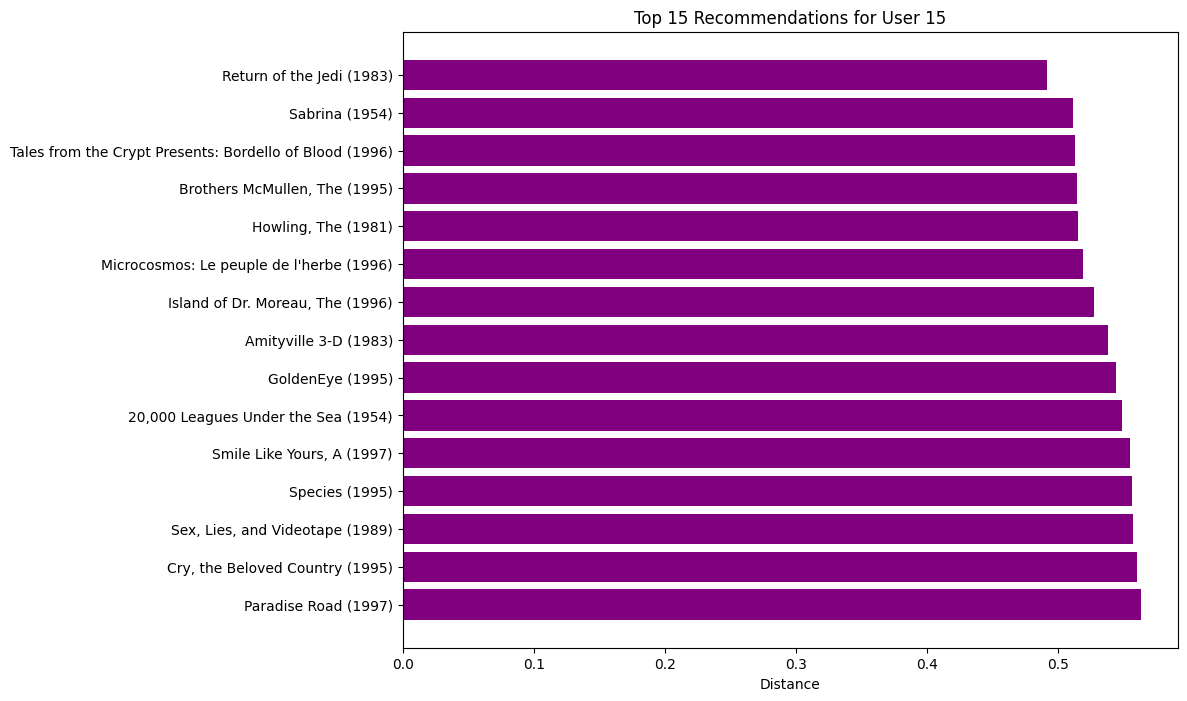

In [ ]:
# Get recommendations and visualize for user_id 3
user_id = 15
num_recommendations = 15
recommendations = recommend_movies_visual(user_id, num_recommendations, 'purple')


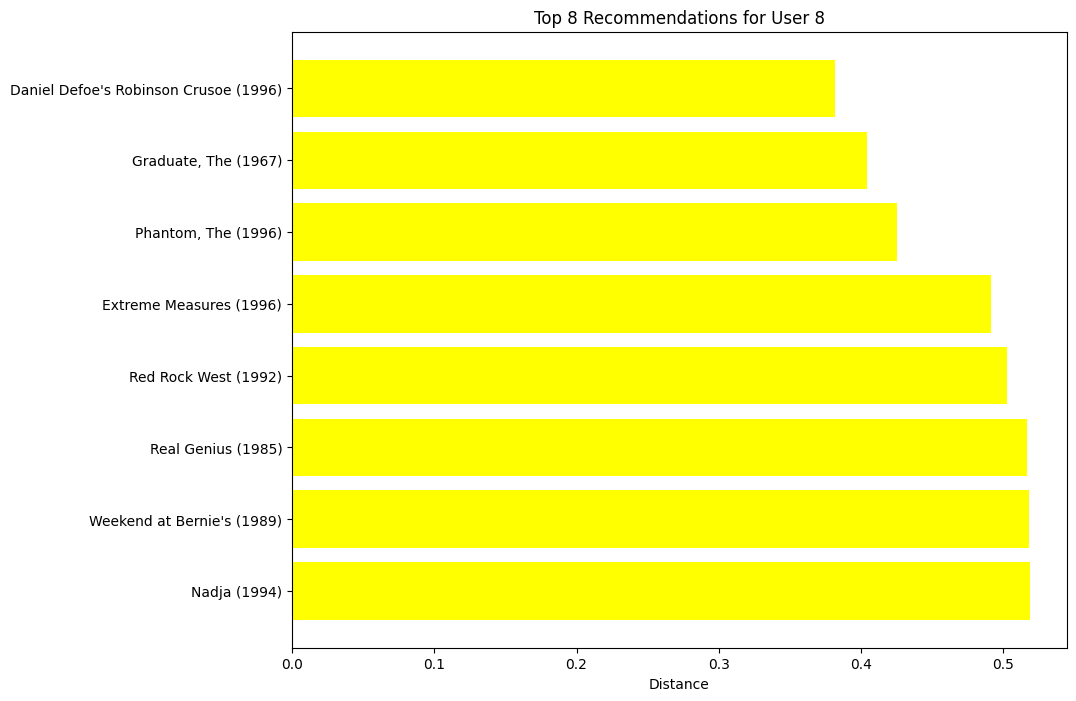

In [ ]:
# Get recommendations and visualize for user_id 3
user_id = 8
num_recommendations = 8
recommendations = recommend_movies_visual(user_id, num_recommendations, 'yellow')


*END*

#MODEL 2:Collaborative filtering model using matrix factorization with embeddings in TensorFlow/Keras.

##packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load MovieLens 100k dataset & Preprocess data


In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings_data = pd.read_csv(url, sep='\t', names=columns)

ratings_data['userId'] = ratings_data['userId'].astype('category').cat.codes.values
ratings_data['movieId'] = ratings_data['movieId'].astype('category').cat.codes.values


In [ ]:
# Split data into training and testing sets
train, test = train_test_split(ratings_data, test_size=0.2, random_state=42)


##Build recommendation model

In [ ]:
# Build recommendation model
num_users = len(ratings_data['userId'].unique())
num_movies = len(ratings_data['movieId'].unique())
embedding_size = 50

user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
movie_input = tf.keras.layers.Input(shape=(1,), name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_size, input_length=1, name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=embedding_size, input_length=1, name='movie_embedding')(movie_input)

user_flatten = tf.keras.layers.Flatten()(user_embedding)
movie_flatten = tf.keras.layers.Flatten()(movie_embedding)

prod = tf.keras.layers.Dot(axes=1)([user_flatten, movie_flatten])

model = tf.keras.Model(inputs=[user_input, movie_input], outputs=prod)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([train['userId'], train['movieId']], train['rating'],
                    batch_size=64, epochs=10,
                    validation_data=([test['userId'], test['movieId']], test['rating']))

Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 9.0913 - val_loss: 1.9742
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2915 - val_loss: 1.0375
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9556 - val_loss: 0.9489
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8972 - val_loss: 0.9238
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8614 - val_loss: 0.9059
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8237 - val_loss: 0.8883
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7835 - val_loss: 0.8711
Epoch 8/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7409 - val_loss: 0.8640
Epoch 9/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7002 - val_loss: 0.8610
Epoch 10/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.656

##Visualise training history

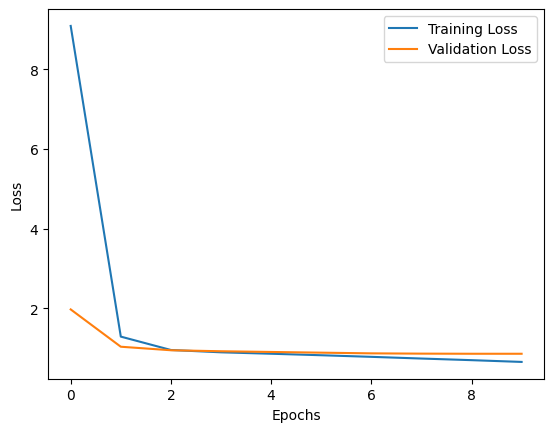

1/1 [==============================] - 0s 32ms/step
Predicted rating for user 5 and movie 12: 3.4013187885284424


In [ ]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Example prediction
user_id = 5  # Example user ID
movie_id = 12  # Example movie ID
predicted_rating = model.predict([np.array([user_id]), np.array([movie_id])])
print(f'Predicted rating for user {user_id} and movie {movie_id}: {predicted_rating[0][0]}')

## Data Analysis

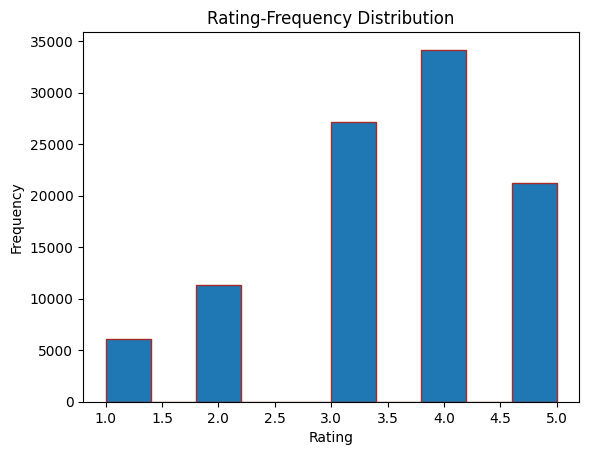

In [ ]:
# Rating distribution
plt.hist(ratings_data['rating'], bins=10, edgecolor='brown')
plt.title('Rating-Frequency Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

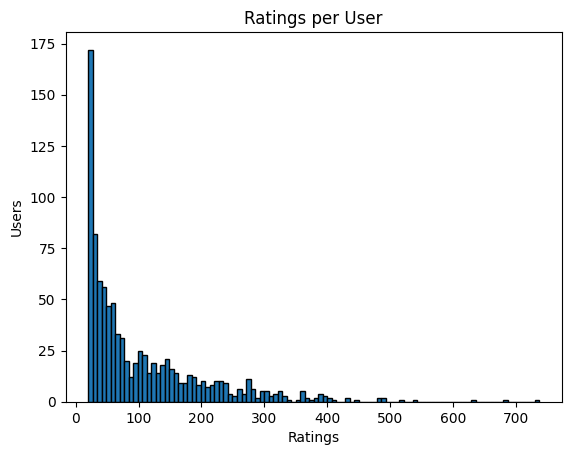

In [ ]:
# Number of ratings per user
ratings_per_user = ratings_data.groupby('userId').size()
plt.hist(ratings_per_user, bins=100, edgecolor='black')
plt.title('Ratings per User')
plt.xlabel('Ratings')
plt.ylabel('Users')
plt.show()

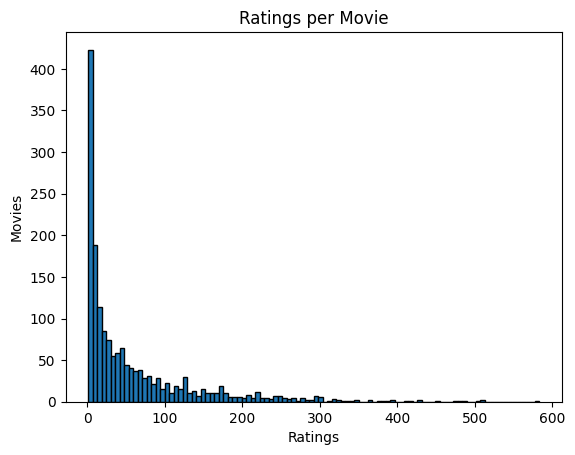

In [ ]:
# Number of ratings per movie
ratings_per_movie = ratings_data.groupby('movieId').size()
plt.hist(ratings_per_movie, bins=100, edgecolor='black')
plt.title('Ratings per Movie')
plt.xlabel('Ratings')
plt.ylabel('Movies')
plt.show()

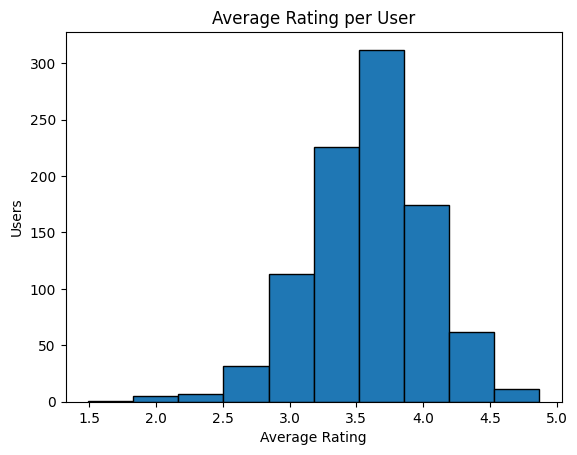

In [ ]:
# Average rating per user
avg_rating_per_user = ratings_data.groupby('userId')['rating'].mean()
plt.hist(avg_rating_per_user, bins=10, edgecolor='black')
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Users')
plt.show()

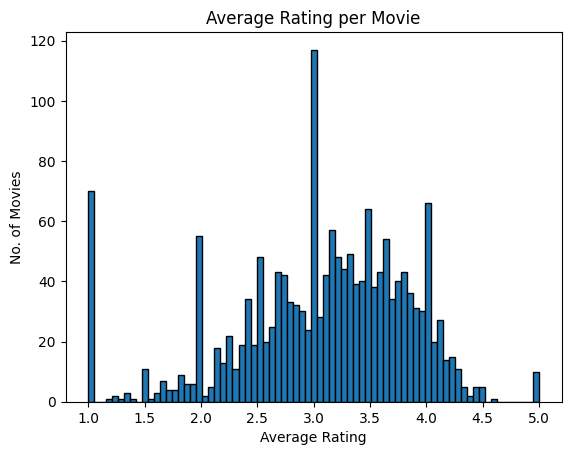

In [ ]:
# Average rating per movie
avg_rating_per_movie = ratings_data.groupby('movieId')['rating'].mean()
plt.hist(avg_rating_per_movie, bins=75, edgecolor='black')
plt.title('Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('No. of Movies')
plt.show()

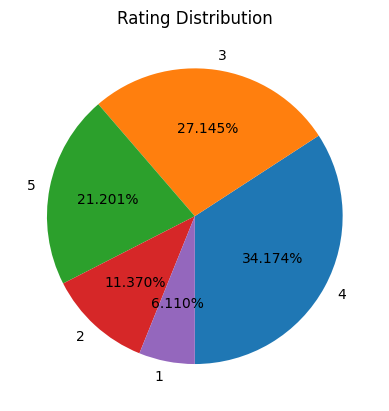

In [ ]:
# Pie chart of ratings
rating_counts = ratings_data['rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%2.3f%%', startangle=270)
plt.title('Rating Distribution')
plt.show()

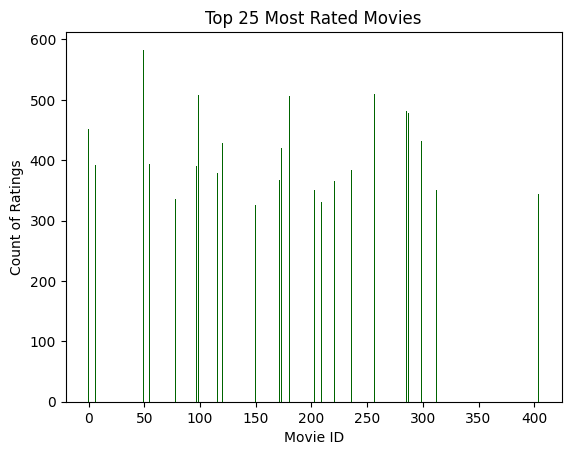

In [ ]:
# Bar plot of top 10 most rated movies
top_25_movies = ratings_data['movieId'].value_counts().head(25)
plt.bar(top_25_movies.index, top_25_movies.values, color='darkgreen')
plt.title('Top 25 Most Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Count of Ratings')
plt.show()

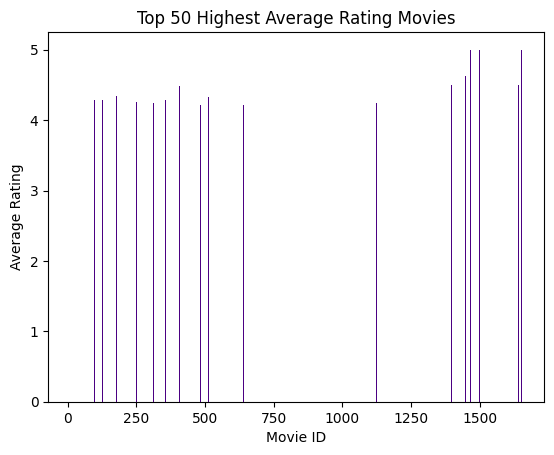

In [ ]:
# Bar plot of top 10 highest average rating movies
top_50_avg_rated_movies = ratings_data.groupby('movieId')['rating'].mean().nlargest(50)
plt.bar(top_50_avg_rated_movies.index, top_50_avg_rated_movies.values, color='indigo')
plt.title('Top 50 Highest Average Rating Movies')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.show()


*END*

#MODEL 3:Graph Neural Network

##packages

In [9]:
!pip install -q tensorflow-recommenders matplotlib scikit-learn tabulate

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from tabulate import tabulate


# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

# Convert the movie titles to a TensorFlow Dataset
movies = tf.data.Dataset.from_tensor_slices(list(movies))

##Defining GNN Layer

In [5]:
# Define the GNN layer
class GNNLayer(layers.Layer):
    def __init__(self, units):
        super(GNNLayer, self).__init__()
        self.units = units
        self.dense = layers.Dense(units)

    def call(self, inputs, edge_index):
        x = inputs
        row, col = edge_index[:, 0], edge_index[:, 1]
        out = tf.math.unsorted_segment_sum(x[col], row, num_segments=tf.shape(x)[0])
        return self.dense(out)

class GNNModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def call(self, features):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        edge_index = tf.convert_to_tensor([features["user_id"], features["movie_title"]])
        gnn_layer = GNNLayer(64)
        user_embeddings = gnn_layer(user_embeddings, edge_index)
        movie_embeddings = gnn_layer(movie_embeddings, edge_index)
        return self.task(user_embeddings, movie_embeddings)

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)


## defining models and compiling

In [7]:

# Define user and movie models
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the task
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Create and compile the model
model = GNNModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model and capture the training history
history = model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)


Epoch 1/10
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_5_categorical_accuracy: 0.0051 - factorized_top_k/top_10_categorical_accuracy: 0.0098 - loss: 32365.8578 - regularization_loss: 0.0000e+00 - total_loss: 32365.8578
Epoch 2/10
25/25 [==============================] - 22s 875ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0076 - factorized_top_k/top_10_categorical_accuracy: 0.0164 - loss: 31418.9772 - regularization_loss: 0.0000e+00 - total_loss: 31418.9772
Epoch 3/10
25/25 [==============================] - 16s 630ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0086 - factorized_top_k/top_10_categorical_accuracy: 0.0186 - loss: 30845.5549 - regularization_loss: 0.0000e+00 - total_loss: 30845.5549
Epoch 4/10
25/25 [==============================] - 16s 630ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0123 - factorized_top_k/top_10_categorical_accuracy: 0.0260 - loss: 30475.1194 - regularization_loss: 0.0000e+00 - total_loss

##Analysis and output


Top 10 recommendations for user 5:
╒════════╤═════════════════════════════════════════╕
│   Rank │ Movie Title                             │
╞════════╪═════════════════════════════════════════╡
│      1 │ Amityville Curse, The (1990)            │
├────────┼─────────────────────────────────────────┤
│      2 │ Amityville 1992: It's About Time (1992) │
├────────┼─────────────────────────────────────────┤
│      3 │ NeverEnding Story III, The (1994)       │
├────────┼─────────────────────────────────────────┤
│      4 │ Amityville: A New Generation (1993)     │
├────────┼─────────────────────────────────────────┤
│      5 │ Lassie (1994)                           │
├────────┼─────────────────────────────────────────┤
│      6 │ Burnt Offerings (1976)                  │
├────────┼─────────────────────────────────────────┤
│      7 │ Calendar Girl (1993)                    │
├────────┼─────────────────────────────────────────┤
│      8 │ Flintstones, The (1994)                 │
├────────┼

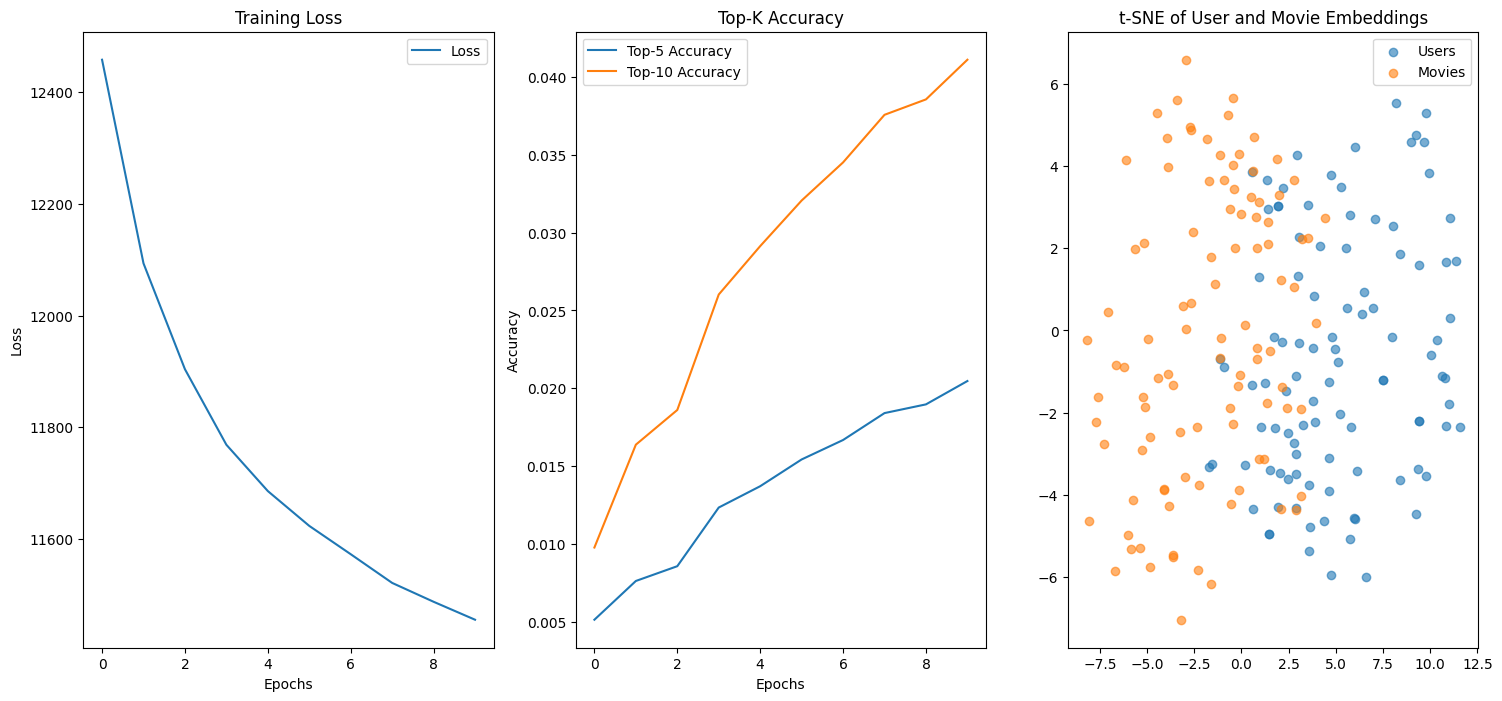

In [13]:
def print_recommendations(user_id):
    _, titles = index(np.array([user_id]))
    top_titles = titles[0, :10].numpy()
    print(f"\nTop 10 recommendations for user {user_id}:")
    print(tabulate(enumerate(top_titles, 1), headers=["Rank", "Movie Title"], tablefmt="fancy_grid"))
# Get and print recommendations for a specific user
print_recommendations("5")

# Get and print recommendations for another user
print_recommendations("28")

# Plot the training loss and top-k accuracy
plt.figure(figsize=(18, 8))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot top-5 and top-10 accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label='Top-5 Accuracy')
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'], label='Top-10 Accuracy')
plt.title('Top-K Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Extract embeddings for visualization
user_embeddings = []
movie_embeddings = []
for user_id in ratings.map(lambda x: x["user_id"]).take(100):
    user_embeddings.append(model.user_model(np.array([user_id.numpy()])))

for movie_title in movies.take(100):
    movie_embeddings.append(model.movie_model(np.array([movie_title.numpy()])))

user_embeddings = np.vstack(user_embeddings)
movie_embeddings = np.vstack(movie_embeddings)

# Use t-SNE for dimensionality reduction
user_tsne = TSNE(n_components=2).fit_transform(user_embeddings)
movie_tsne = TSNE(n_components=2).fit_transform(movie_embeddings)

# Plot embeddings using t-SNE
plt.subplot(1, 3, 3)
plt.scatter(user_tsne[:, 0], user_tsne[:, 1], label='Users', alpha=0.6)
plt.scatter(movie_tsne[:, 0], movie_tsne[:, 1], label='Movies', alpha=0.6)
plt.title('t-SNE of User and Movie Embeddings')
plt.legend()

plt.show()

*END*